# Introduction
## Exploring the Worlds 2021 Play-In Tournament Data

For this project, we're exploring the Group Stage data from the Worlds 2021 League of Legends Play-In matches. We want to identify the player stat category that seems to correlate most with a team's success in the tournament and use a linear regression model to identify other factors that contribute to higher stats in that particular category.

**Hypothesis**: Our hypothesis is that team objectives play the biggest part in a team's success, which we will measure based on the team objective's contribution to the player stat that shows the most distinct difference between players that won or loss from our exploratory data analysis.

<img width="600" height="" align="left" src="https://www.touchtapplay.com/wp-content/uploads/2021/07/league-of-legends-map.jpg">


In [1]:
# First, let's import all the necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_1samp, ttest_ind

## Dataset

This dataset was taken from https://www.kaggle.com/braydenrogowski/league-of-legends-worlds-2021-playin-group-stats

Additional information was also taken from https://lol.fandom.com/wiki/2021_Season_World_Championship/Play-In/Scoreboards 

The dataset was combined in Excel and shows the player's individual game stats per match such as kills, deaths, assists and gold earned. In addition, data is also provided on the team's stats for objectives such as Dragons, Barons and Heralds. Please note that the team objective data is duplicated for each player on the same team for the same match.

### Column Legend:
- **Team/Team Name** - The player's team
- **Player** - Player's game ID
- **Opponent/Opponent Name** - The opposing team
- **Position** - The player's role in the game
- **Champion** - The game character that the player was using for that match
- **Kills** - How many times a player landed the killing blow to an opposing player in that match
- **Deaths** - How many times a player died in that match
- **Assists** - How many times a player assisted in killing an opposing player in that match
- **Creep Score** - How many minions/jungle monsters a player landed the killing blow for in that match
- **Gold Earned** - How much gold did that player earn in that match
- **Champion Damage Share** - Percentage share of damage dealt to opposing champions by player in that match
- **Kill Participation** - Percentage of participation in overall Kills or Assists by player in that match
- **Wards Placed** - Total number of wards placed on the map
- **Wards Destroyed** - Total number of opposing team's wards destroyed
- **Ward Interactions** - Total number of times player interacted with enemy wards
- **Dragons For** - Total number of Dragons player's team acquired in that match
- **Dragons Against** - Total number of Dragons opposing team acquired in that match
- **Barons For** - Total number of Barons player's team acquired in that match
- **Barons Against** - Total number of Barons opposing team acquired in that match
- **Result** - Whether the player's team won ("W") or loss ("L") the match
- **Herald For** - Total number of Heralds player's team acquired in that match
- **Herald Against** - Total number of Heralds opposing team acquired in that match

In [2]:
# Let's load in our data
WorldsData = pd.read_excel('League_PlayIn_Data.xlsx', 'PlayInGroupsData')
WorldsData.head()

,Team,Team Name,Player,Opponent,Opponent Name,Position,Champion,Kills,Deaths,Assists,...,Wards Placed,Wards Destroyed,Ward Interactions,Dragons For,Dragons Against,Barons For,Barons Against,Result,Herald For,Herald Against
0,UOL,Unicorns of Love,Boss,GS,Galatasaray Esports,Top,Camille,4,5,3,...,8,8,16,0,4,0,1,L,1,1
1,GS,Galatasaray Esports,Crazy,UOL,Unicorns of Love,Top,Gwen,3,1,9,...,10,7,17,4,0,1,0,W,1,1
2,UOL,Unicorns of Love,Ahahacik,GS,Galatasaray Esports,Jungle,Trundle,2,4,5,...,8,14,22,0,4,0,1,L,1,1
3,GS,Galatasaray Esports,Mojito,UOL,Unicorns of Love,Jungle,Talon,5,4,10,...,12,8,20,4,0,1,0,W,1,1
4,UOL,Unicorns of Love,Nomanz,GS,Galatasaray Esports,Mid,Leblanc,1,3,4,...,6,9,15,0,4,0,1,L,1,1


In [3]:
# Let's drop some of the redundant columns or data we don't need
WorldsData.drop(columns = ['Team', 'Opponent', 'Barons Against', 'Dragons Against', 'Herald Against'], inplace = True)

# Then let's add a "KDA" column which represents the ratio between Kills and Assists versus Deaths, a common
WorldsData['KDA'] = np.where(
    WorldsData['Deaths'] == 0,  # This was used to avoid the issue of getting an infinite value when dividing by 0
    round(WorldsData['Kills'] + WorldsData['Assists'], 2),
    round((WorldsData['Kills'] + WorldsData['Assists']) / WorldsData['Deaths'],2))

WorldsData.head()

,Team Name,Player,Opponent Name,Position,Champion,Kills,Deaths,Assists,Creep Score,Gold Earned,Champion Damage Share,Kill Participation,Wards Placed,Wards Destroyed,Ward Interactions,Dragons For,Barons For,Result,Herald For,KDA
0,Unicorns of Love,Boss,Galatasaray Esports,Top,Camille,4,5,3,188,11107,0.17,0.78,8,8,16,0,0,L,1,1.40
1,Galatasaray Esports,Crazy,Unicorns of Love,Top,Gwen,3,1,9,217,12201,0.20,0.52,10,7,17,4,1,W,1,12.00
2,Unicorns of Love,Ahahacik,Galatasaray Esports,Jungle,Trundle,2,4,5,156,9048,0.15,0.78,8,14,22,0,0,L,1,1.75
3,Galatasaray Esports,Mojito,Unicorns of Love,Jungle,Talon,5,4,10,194,11234,0.23,0.65,12,8,20,4,1,W,1,3.75
4,Unicorns of Love,Nomanz,Galatasaray Esports,Mid,Leblanc,1,3,4,216,9245,0.29,0.56,6,9,15,0,0,L,1,1.67


# Exploratory Data Analysis

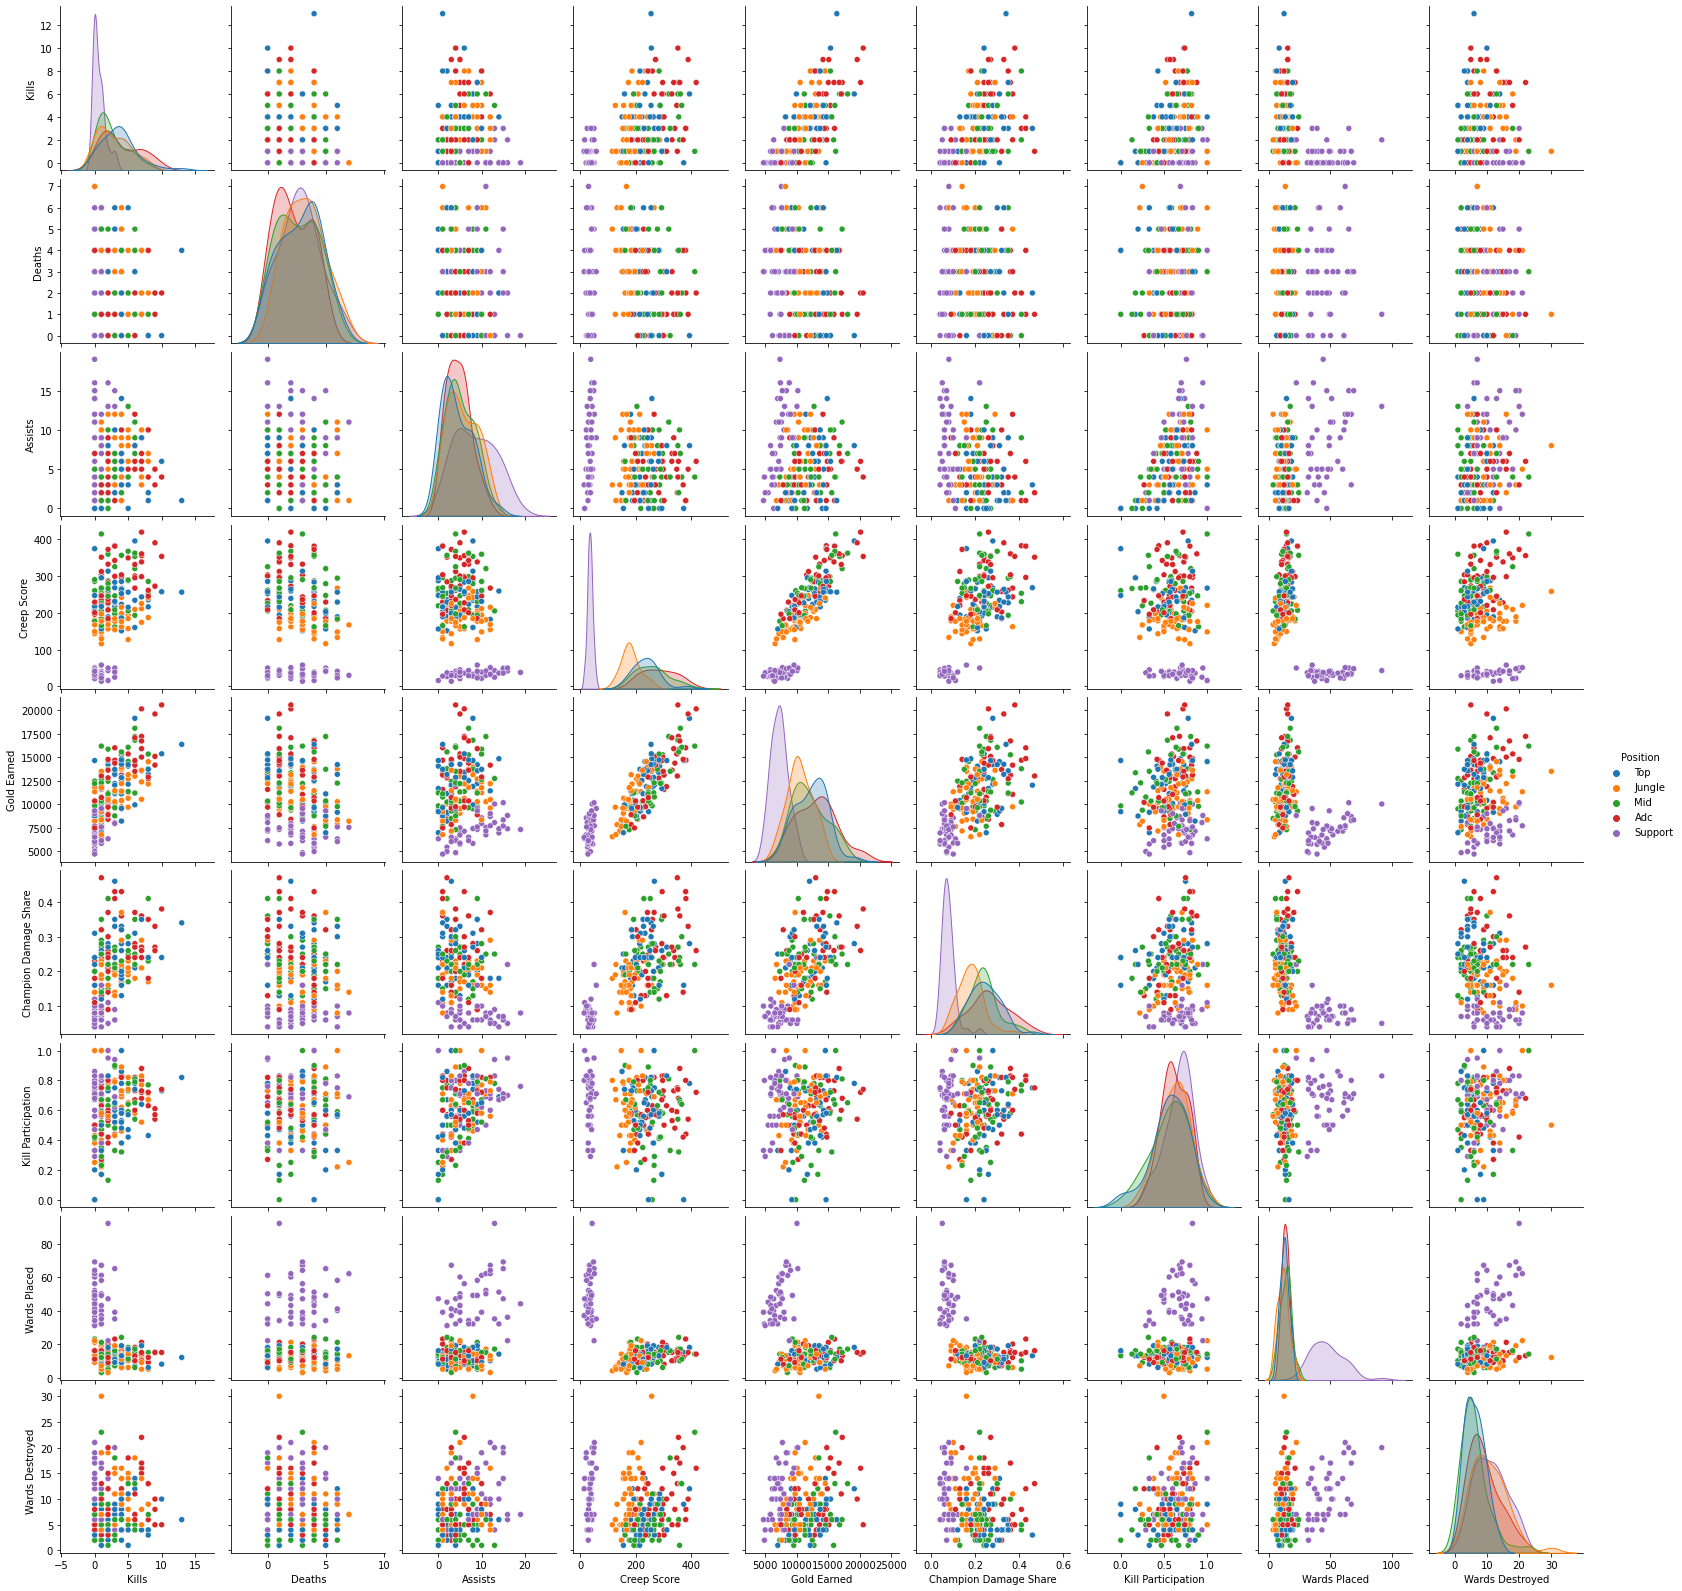

In [4]:
# Let's take a preliminary look at some of the player's individual stats split based on their position in the game

subset_Worlds = WorldsData.iloc[:,3:14]
sns.pairplot(subset_Worlds, hue="Position")

Preliminary analysis shows how the support position stands out from the other roles. In particular, they fall short compared to other roles in Kills, Creep Score, Gold Earned and Champion Damage Share but are high in the Wards Placed department. This is namely due to the nature of the role, which doesn't require any "farming" during the "laning phase" of the game and relies more heavily on assisting the team during team fights or strategically placing wards in appropriate locations to provide the team with vision of the map and of the opposing team.

## Factors related to Wins or Losses based on Individual Player Stats

### Creep Score

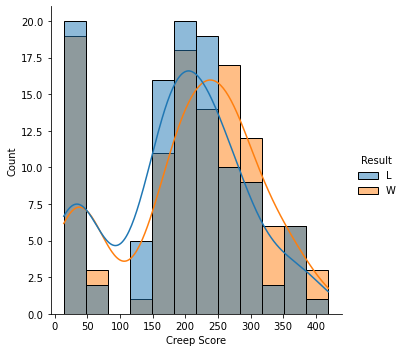

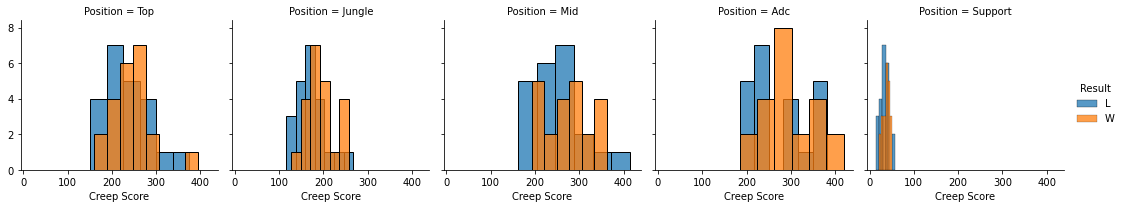

In [5]:
# Plotting the distribution for Creep Score for players that won vs players that loss their matches
sns.displot(WorldsData, x = "Creep Score", hue = 'Result', kde=True)

# This was also broken down by position given the bimodal distribution see in the first graph
grid = sns.FacetGrid(WorldsData, col = "Position", hue = "Result", col_wrap=5)
grid.map(sns.histplot,"Creep Score")
grid.add_legend()

In [6]:
# Since the difference isn't as apparent visually, let's look at the average creep score table below for comparison
WorldsData[["Result", "Position", "Creep Score"]].groupby(["Result", "Position"]).mean()

Creep Score
Result Position             
L      Adc        273.545455
       Jungle     172.500000
       Mid        245.681818
       Support     32.681818
       Top        231.863636
W      Adc        298.454545
       Jungle     192.954545
       Mid        274.318182
       Support     37.181818
       Top        244.227273

In [7]:
# Ttest to compare the creep scores between players that won and those that loss
# Excluded Supports since they do not CS
ttest_ind(WorldsData[(WorldsData["Result"] == "W") & (WorldsData["Position"] != "Support")]["Creep Score"],
          WorldsData[(WorldsData["Result"] == "L") & (WorldsData["Position"] != "Support")]["Creep Score"],
          alternative='two-sided')

Ttest_indResult(statistic=2.22712091346054, pvalue=0.02722183115902894)

We can see overall that the creep score is slightly higher for players that are winning for positions that are dependent on creep score (Mid, ADC, Jungle and Top). The position with the highest difference in average creep score between the winning and losing team was in Mid followed closely by Adc, then Jungle and lastly Top. We don't see much difference here for Supports since they're role does not rely on last hitting minions/jungle monsters. 

In general our t-test indicates that creep score is a significant factor in determining whether a professional player will win or lose a match for the all positions except for Support.

### Gold Earned

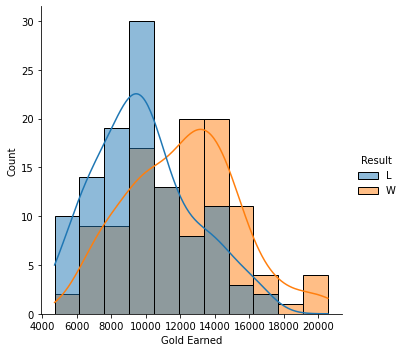

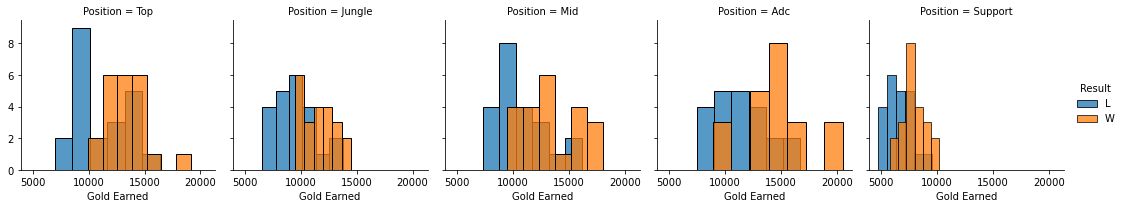

In [8]:
# Plotting the distribution for Gold Earned for players that won vs players that loss their matches
sns.displot(WorldsData, x = "Gold Earned", hue = 'Result', kde=True)

# This was also broken down by position
grid = sns.FacetGrid(WorldsData, col = "Position", hue = "Result", col_wrap=5)
grid.map(sns.histplot,"Gold Earned")
grid.add_legend()

In [9]:
# Ttest to compare the gold earned between players that won and those that loss
ttest_ind(WorldsData[WorldsData["Result"] == "W"]["Gold Earned"],
          WorldsData[WorldsData["Result"] == "L"]["Gold Earned"],
          alternative='two-sided')

Ttest_indResult(statistic=5.6629794863189575, pvalue=4.664956492986764e-08)

It's quite apparent that gold earned is a clear measure for how well a player is doing. This makes sense, considering gold is the currency earned on all objectives in the game - whether it's kills, assists, destroying enemy wards or towers, damaging enemy champions, or clearing team objectives like dragons.

### KDA: Kills + Assists vs Deaths Ratio

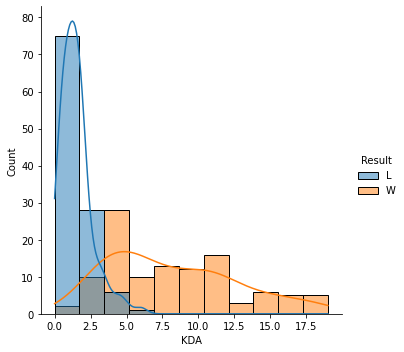

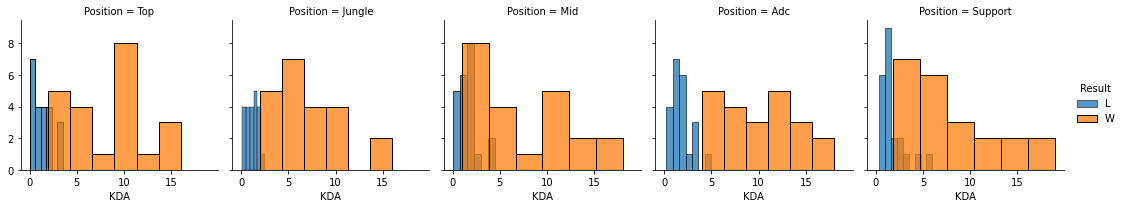

In [10]:
# Plotting the distribution for KDA for players that won vs players that loss their matches
sns.displot(WorldsData, x = "KDA", hue = 'Result', kde=True)

# This was also broken down by position
grid = sns.FacetGrid(WorldsData, col = "Position", hue = "Result", col_wrap=5)
grid.map(sns.histplot,"KDA")
grid.add_legend()

In [11]:
# Ttest to compare the gold earned between players that won and those that loss
ttest_ind(WorldsData[WorldsData["Result"] == "W"]["KDA"],
          WorldsData[WorldsData["Result"] == "L"]["KDA"],
          alternative='two-sided')

Ttest_indResult(statistic=15.18146889642989, pvalue=5.333364180576791e-36)

KDA seems to show the most distinct difference between the winning and losing team, demonstrating that high kills and assists to deaths ratio is a significant indicator of a player's success in the game. Winning team fights or picking off enemy players swing the game drastically in the team's favor overall. With this we can see that surviving in the game and picking the right fights is very important. 

We'll use this category later on given it's significanct difference between players that won and loss to look at what factors contribute the most to having a high KDA.

## Factors related to Wins or Losses based on Team Objectives

### Heralds
Interestingly enough, the Herald does not seem to have a significant impact on a team's success. The Herald, when used by the team that acquired it, will automatically target the closest enemy tower and deal significant damage to it while it's still alive. A lot of teams strategize using it while other team objectives like the Dragon is up as a means for distraction and splitting the enemy's focus. Given this strategy, it may be more likely that the better timing and use of the Herald has a greater impact as opposed to simply obtaining the objective.

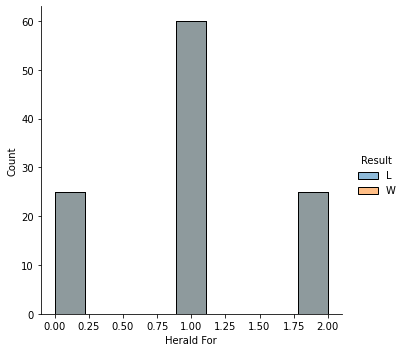

In [12]:
sns.displot(WorldsData, x = "Herald For", hue = 'Result')

### Dragons
Each Dragon acquired provides a permanent team buff. Not surprisingly, acquiring more Dragons (particularly four which leads to a team buff referred to as the "Soul"), leads to higher success in the game.  

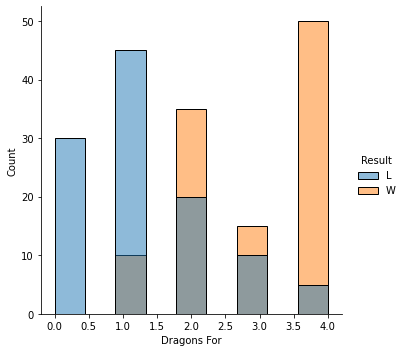

In [13]:
sns.displot(WorldsData, x = "Dragons For", hue = 'Result')

### Barons
We see the most distinct difference with the Baron, which gives a temporary team buff that also applies to the minions/creeps that are walking near team that acquires the buff. Teams that were able to obtain this objective were much more likely to win.

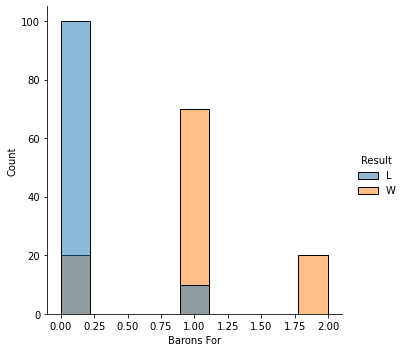

In [14]:
sns.displot(WorldsData, x = "Barons For", hue = 'Result')

# Linear Regression Model for KDA

Given the significant correlation between KDA and whether a player wins their match, I wanted to use a linear regression model to look at what factors had the most impact on KDA.

<AxesSubplot:>

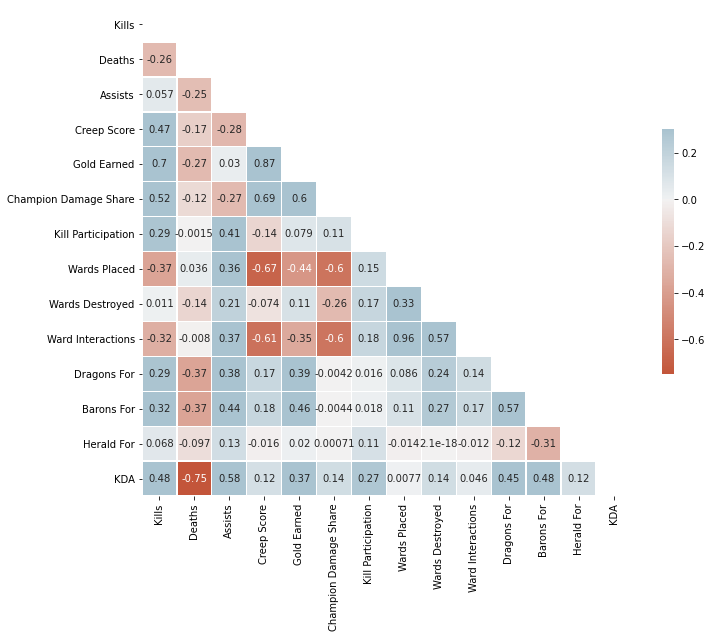

In [15]:
# First let's do a quick correlation analysis
correlation = WorldsData.corr()

# Creating a half-matrix for our correlation figure
mask = np.triu(np.ones_like(correlation, dtype=bool))

# General dimension for our plot
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Creating our heatmap for our correlation matrix
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

We see that Kills, Deaths and Assists correlate with KDA. But given that KDA is calculated based on these values, for the purpose of the model I decided to leave these out. We can already see that team objectives like the Dragon and Baron seem to show some correlation with KDA.

## First Model
Let's do a linear regression model analysis with all of the factors as a starting off point

In [16]:
# Constant was not used since it decreased the R-squared value by a large margin (was returning R-squared of 0.432)
# Kills, Deaths and Assists were not included since KDA is calculated using these factors

dependent_vars = WorldsData["KDA"]
independent_vars = WorldsData[["Gold Earned", "Creep Score", "Champion Damage Share", "Kill Participation", "Wards Placed", "Wards Destroyed", "Ward Interactions", "Dragons For", "Barons For", "Herald For"]]


dependent_vars = dependent_vars.apply(float)
independent_vars = independent_vars.applymap(float)

lin_reg = sm.OLS(dependent_vars, independent_vars) # Initialize our model based on the ordinarily squared model
reg_results = lin_reg.fit() # Optimizes the fit to the model
print(reg_results.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                    KDA   R-squared (uncentered):                   0.716
Model:                            OLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                              59.23
Date:                Wed, 15 Dec 2021   Prob (F-statistic):                    6.36e-53
Time:                        16:37:32   Log-Likelihood:                         -591.60
No. Observations:                 220   AIC:                                      1201.
Df Residuals:                     211   BIC:                                      1232.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

We see in the model above that there are a few factors that can be removed due to the high p-values:
- Gold Earned
- Champion Damage Share
- Wards Placed
- Wards Destroyed

## Second Model
Although our R-squared decreases a little, our P-values for each factor looks much better compared to before after dropping those factors.

In [17]:
# We run the model a second time with the above factors removed
independent_vars2 = independent_vars[["Creep Score", "Kill Participation", "Ward Interactions", "Dragons For", "Barons For", "Herald For"]]

dependent_vars = dependent_vars.apply(float)
independent_vars2 = independent_vars2.applymap(float)

lin_reg2 = sm.OLS(dependent_vars, independent_vars2) # Initialize our model based on the ordinarily squared model
reg_results2 = lin_reg2.fit() # Optimizes the fit to the model
print(reg_results2.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                    KDA   R-squared (uncentered):                   0.711
Model:                            OLS   Adj. R-squared (uncentered):              0.703
Method:                 Least Squares   F-statistic:                              87.90
Date:                Wed, 15 Dec 2021   Prob (F-statistic):                    5.44e-55
Time:                        16:37:32   Log-Likelihood:                         -593.55
No. Observations:                 220   AIC:                                      1199.
Df Residuals:                     214   BIC:                                      1219.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

# Conclusions
From this we can see that overall team objectives seem to play a big role in increasing a player's KDA. Surprisingly, obtaining Heralds also still contribute to high KDA despite the lack of significant difference between winning and losing teams. Overall, this is consistent with current team strategies that heavily revolves around team fights that break out in order to obtain these team objectives. As a result, those that win the fight not only have higher KDAs but also are able to obtain the objectives. This also makes sense considering that high kill participation also plays a big part in KDA.

Interestingly enough, creep score and ward interactions decrease KDA. This suggests that a balance needs to be made in terms of focusing on keeping up a good creep score versus actually attacking the opponent players. Ward interactions also emphasize the importance of good vision on the map and how being seen by the enemy team prior to a fight can put yourself at a disadvantage.